13:10:10 - cmdstanpy - INFO - Chain [1] start processing
13:10:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/mq/l3d9x9j17q37b0ngctfcb5ph0000gn/T/ipykernel_14297/3830497890.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future.fillna(method='ffill', inplace=True)
/var/folders/mq/l3d9x9j17q37b0ngctfcb5ph0000gn/T/ipykernel_14297/3830497890.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future.fillna(method='ffill', inplace=True)


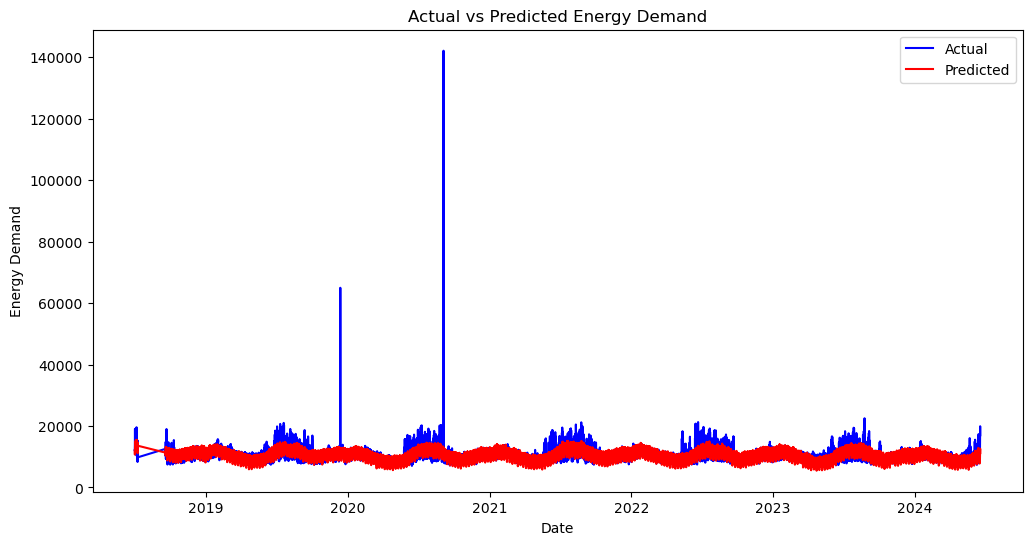

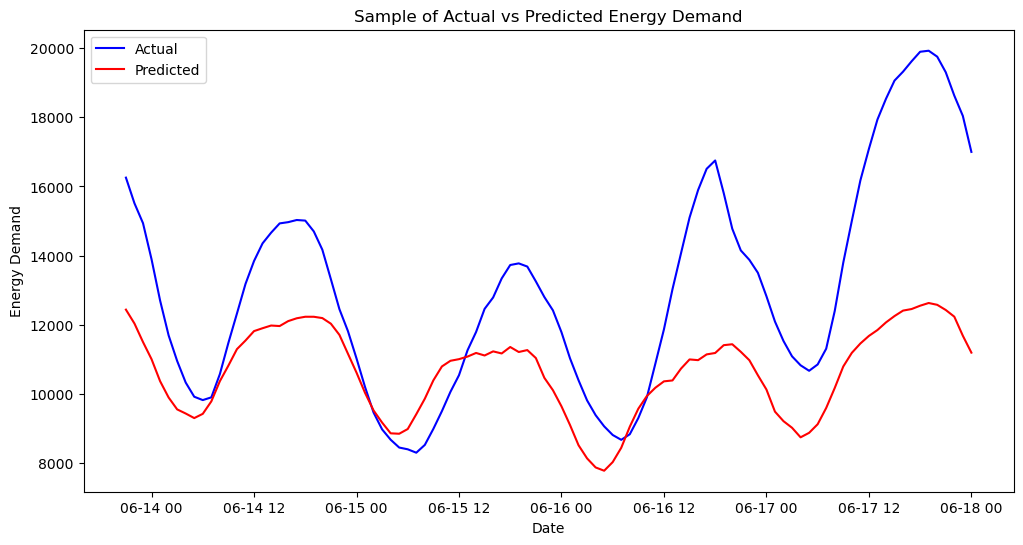

MAPE excluding zeros: 9.164272906104138


In [3]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_excel('../City-Specific Data/Chicago.xlsx')
data = data.dropna()

data['l'] = pd.to_datetime(data['l'])
df = data.rename(columns={'l': 'ds', 'EnergyDemand': 'y'})

model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')

model.fit(df)

future = model.make_future_dataframe(periods=0)
future['Temperature'] = df['Temperature']
future['DewPoint'] = df['DewPoint']
future['WindSpeed'] = df['WindSpeed']
future['Pressure'] = df['Pressure']
future['RelativeHumidity'] = df['RelativeHumidity']

future.fillna(method='ffill', inplace=True)

forecast = model.predict(future)

df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

if len(aligned_df['y']) != len(aligned_df['yhat']):
    print(f"Length mismatch: Actual = {len(aligned_df['y'])}, Predicted = {len(aligned_df['yhat'])}")

plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index, aligned_df['y'], label='Actual', color='b')
plt.plot(aligned_df.index, aligned_df['yhat'], label='Predicted', color='r')
plt.title('Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

sample_period = 100
plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r')
plt.title('Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

non_zero_data = aligned_df[aligned_df['y'] != 0]
non_zero_errors = np.abs((non_zero_data['y'] - non_zero_data['yhat']) / non_zero_data['y'])
non_zero_mape = non_zero_errors.mean() * 100
print("MAPE excluding zeros:", non_zero_mape)